# Visualize TCGA confounding factors

In [1]:
library(dplyr)
library(ggplot2)
library(ggpubr)
library(ggsci)
library(patchwork)
library(aplot)
library(ggrastr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




### Functions 

In [2]:
set.seed(7)

In [3]:
plot_confounder_embedding<-function(anot.embed,...){
    
    col.pal <- colorRampPalette(colors = c( "#115f9a", "#1984c5", "#22a7f0", "#48b5c4", "#76c68f", "#a6d75b", "#c9e52f", "#d0ee11", "#d0f400"))
    
    colnames(anot.embed)<-gsub("_.*","",colnames(anot.embed))
    
    p1<-anot.embed %>%
        ggplot(.,aes(x=PC1,y=PC2,color=impurity))+
        rasterise(geom_point(size=1.25,na.rm=TRUE),dpi=300)+
        theme_pubr()+
        scale_color_gradientn(colours = col.pal(10))+
        theme(legend.position="right")
    
    p2<-anot.embed %>%
        ggplot(.,aes(x=PC1,y=PC3,color=impurity))+
        rasterise(geom_point(size=1.25,na.rm=TRUE),dpi=300)+
            theme_pubr()+
            scale_color_gradientn(colours = col.pal(10))+
            theme(legend.position="right")
    
    return(list(p1,p2))
}

### Load data

In [4]:
load("../input/tcga.metadata.RData")
load("../input/tcga.SE.splicing.embeddings.RData")
load("../input/tcga.gene.expression.embeddings.RData")

In [5]:
length(unique(metadata$cancer))

[1] 31

In [6]:
tcga.colors<-c("#EF9A9A","#F8BBD0","#CE93D8","#B39DDB","#9FA8DA",
               "#90CAF9","#81D4FA","#80DEEA","#80CBC4","#A5D6A7",
               "#C5E1A5","#E6EE9C","#FFF59D","#FFE082","#BCAAA4",
               "#F44336","#E91E63","#9C27B0","#673AB7","#3F51B5",
               "#2196F3","#03A9F4","#00BCD4","#009688","#4CAF50",
               "#8BC34A","#CDDC39","#FFC107","#FF9800","#795548",
               "#B71C1C")

## Full dataset

### Expression

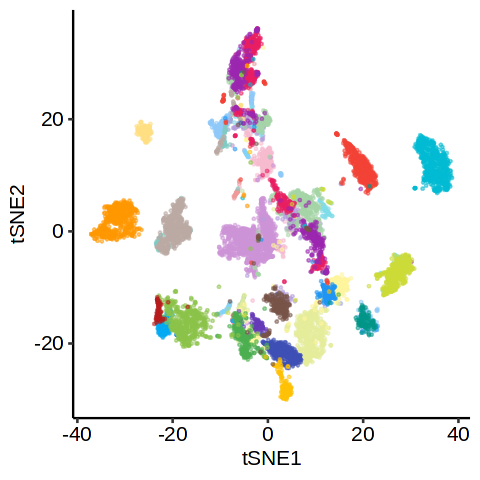

In [7]:
options(repr.plot.height=4,repr.plot.width=4)
gem<-left_join(metadata,gene_embed,by = "submitter_id") 
p1<-ggplot(gem,aes(x=tSNE1_exp,y=tSNE2_exp,color=cancer))+
        rasterise(geom_point(size=0.5,alpha=0.5),dpi=300)+
        theme_pubr()+
        theme(legend.position="none")+
        scale_color_manual(values=tcga.colors)+
        labs(x="tSNE1",y="tSNE2")
ggsave(p1,filename="../output/embeddings/global/tcga.gex.tSNE.embeding.cancerType.pdf",device="pdf",height = 4,width=4,units="in")
p1

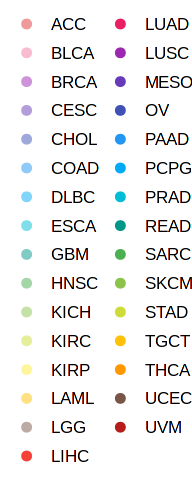

In [8]:
options(repr.plot.height=4,repr.plot.width=1.6)
p1<-ggplot(gem,aes(x=tSNE1_exp,y=tSNE2_exp,color=cancer))+
    geom_point(size=2)+
    theme_pubr()+
    theme(legend.position="top")+
    scale_color_manual(values=tcga.colors)+
    guides(color=guide_legend(ncol=2))+
    labs(color="")
l<-as_ggplot(get_legend(p1))
ggsave(l,filename="../output/embeddings/global/tcga.gex.tSNE.embeding.cancerType.legend.long.pdf",device="pdf",height = 4,width=1.6,units="in")
l

### Splicing

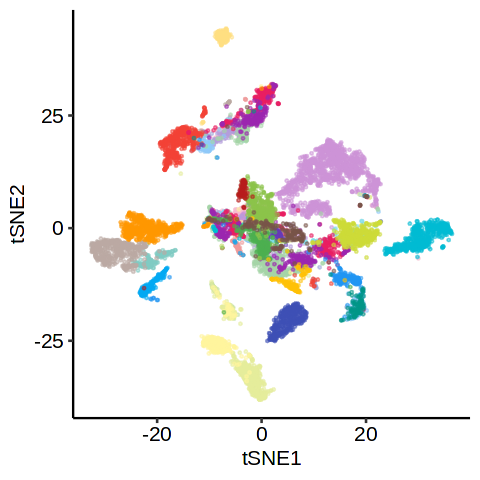

In [9]:
options(repr.plot.height=4,repr.plot.width=4)
splem<-left_join(metadata,spl_embed,by = "submitter_id") 
p1<-ggplot(splem,aes(x=tSNE1_spl,y=tSNE2_spl,color=cancer))+
        rasterise(geom_point(size=0.5,alpha=0.5),dpi=300)+
        theme_pubr()+
        theme(legend.position="none")+
        scale_color_manual(values=tcga.colors)+
        labs(x="tSNE1",y="tSNE2")
ggsave(p1,filename="../output/embeddings/global/tcga.spl.tSNE.embeding.cancerType.pdf",device="pdf",height = 4,width=4,units="in")
p1

## By cancer type

In [10]:
#cancers<-unique(metadata$cancer)
cancers<-"KIRC"
metadata<-metadata %>% filter(condition=="tumor")

Analyzing KIRC

Plotting embeddings...

Computing PC correlations...



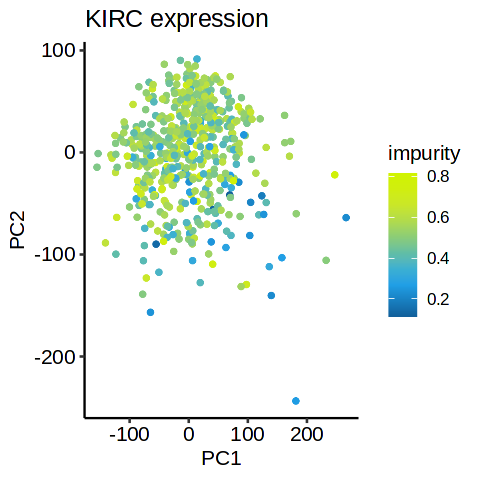

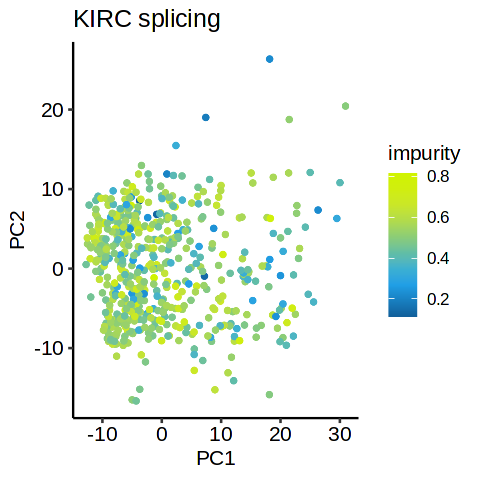

In [11]:
allcors<-list()
spl_pca_objs<-list()
gex_pca_objs<-list()
for(ctype in cancers){
    
    message("Analyzing ",ctype)
    
    load(file=paste0("../input/by_cancer/",ctype,".SE.splicing.embeddings.RData"),verbose = F)
    load(file=paste0("../input/by_cancer/",ctype,".gene.expression.embeddings.RData"),verbose = F)
    load(file=paste0("../input/by_cancer/",ctype,".SE.splicing.prcomp.RData"))
    load(file=paste0("../input/by_cancer/",ctype,".gene.expression.prcomp.RData"))

    spl_pca_objs[[ctype]]<-spl_pca
    gex_pca_objs[[ctype]]<-gn_pca

    # Gene expression embedding plots 
    message("Plotting embeddings...")
    cgem<-inner_join(metadata,gene_embed,by = "submitter_id") %>%
          filter(condition=="tumor")
    
    plots<-plot_confounder_embedding(cgem)
    
    if(ctype=="KIRC"){
        print(plots[[1]] + labs(title="KIRC expression"))
    }
    
    ggsave(plots[[1]],filename=paste0("../output/embeddings/per_cancer/",ctype,".PC1_2.gex.pdf"),device = "pdf",width = 5,height = 4)
    ggsave(plots[[2]],filename=paste0("../output/embeddings/per_cancer/",ctype,".PC1_3.gex.pdf"),device = "pdf",width = 5,height = 4)

    # SE splicing embedding plots 
    csem<-inner_join(metadata,spl_embed,by = "submitter_id") %>%
          filter(condition=="tumor") 
    
    plots<-plot_confounder_embedding(csem)
    
    if(ctype=="KIRC"){
        print(plots[[1]]+labs(title="KIRC splicing"))
    }
    
    ggsave(plots[[1]],filename=paste0("../output/embeddings/per_cancer/",ctype,".PC1_2.spl.pdf"),device = "pdf",width = 5,height = 4)
    ggsave(plots[[2]],filename=paste0("../output/embeddings/per_cancer/",ctype,".PC1_3.spl.pdf"),device = "pdf",width = 5,height = 4)

    # Correlations of impurity with PCs
    message("Computing PC correlations...")
    cgem.cors<-cgem %>%
                  na.omit() %>%
                  select(PC1_exp:PC10_exp,impurity,cancer) %>% 
                  tidyr::pivot_longer(cols = PC1_exp:PC10_exp,names_to = "PC",values_to = "score") %>%
                  mutate(PC=sub("_exp","",PC)) %>%
                  group_by(cancer,PC) %>%
                  summarize(cors=list(cor.test(score,impurity)),.groups="drop") %>%
                  mutate(pcor_impurity=unlist(lapply(cors,function(cr){cr$estimate})),
                        pcor_impurity_pval=unlist(lapply(cors,function(cr){cr$p.value}))) %>%
                  mutate(mode="expression")

    cspl.cors<-csem %>%
                  na.omit() %>%
                  select(PC1_spl:PC10_spl,impurity,cancer) %>% 
                  tidyr::pivot_longer(cols = PC1_spl:PC10_spl,names_to = "PC",values_to = "score") %>%
                  mutate(PC=sub("_spl","",PC)) %>%
                  group_by(cancer,PC) %>%
                  summarize(cors=list(cor.test(score,impurity)),.groups="drop") %>%
                  mutate(pcor_impurity=unlist(lapply(cors,function(cr){cr$estimate})),
                        pcor_impurity_pval=unlist(lapply(cors,function(cr){cr$p.value}))) %>%
                  mutate(mode="splicing")

    allcors[[ctype]]<-rbind(cgem.cors,cspl.cors)
}

### Correlations 

In [12]:
pca.var.cor<-readRDS("../input/pc.impurity.correlations.RDS")

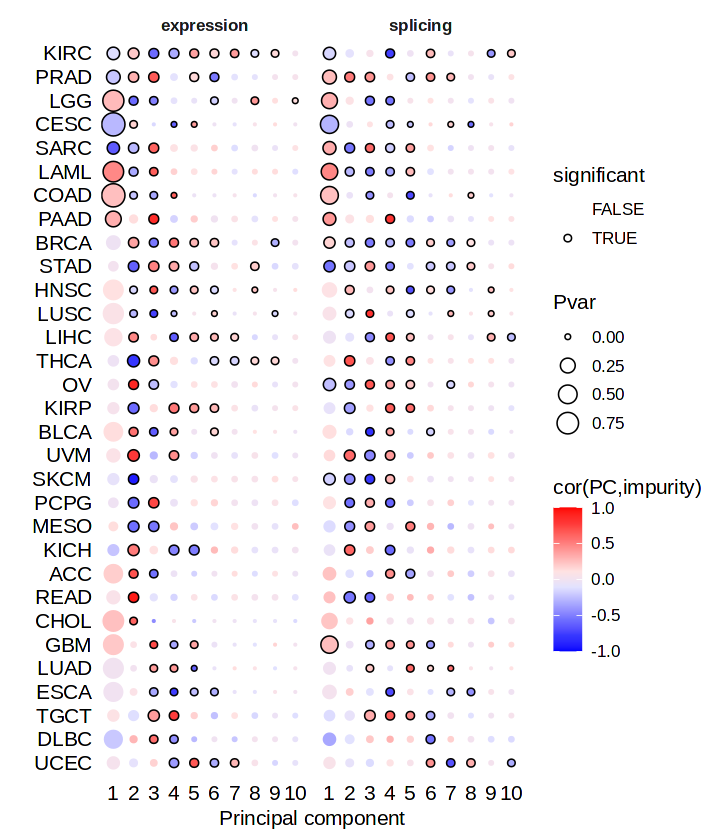

In [13]:
options(repr.plot.width=6,repr.plot.height=7)
col.pal <- colorRampPalette(colors = c("blue","white","red"))
p<-ggplot(pca.var.cor,aes(y=cancer,x=PC,fill=pcor_impurity,color=significant,size=Pvar))+
    geom_point(pch=21)+
    scale_color_manual(values=c("white","black"))+
    scale_x_discrete(position = "bottom")+
    theme_pubr()+
    theme(axis.line = element_blank(),
         axis.ticks = element_blank(),
         legend.position="right",
         strip.background = element_blank(),
         strip.text = element_text(face="bold"))+
    scale_fill_gradientn(colours = col.pal(10),limits=c(-1,1))+
    facet_wrap(~mode)+
    labs(x="Principal component",y="",fill="cor(PC,impurity)")
p

In [14]:
ggsave(p,filename= "../output/correlations/tcga.PCimpurityCorrelations.pdf",device="pdf",width=6,height=7,units="in")
ggsave(p,filename= "../output/correlations/tcga.PCimpurityCorrelations.png",device="png",width=6,height=7,units="in", dpi=1000)